# Settings

In [1]:
import cv2
import glob
import random
import numpy as np
from time import time
from matplotlib import pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils, plot_model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, TensorBoard, Callback

C:\Users\Max\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Prepare data

In [21]:
def load_and_split_data():
    """Loads data from disk and splits into training, tuning and testing set."""
    patches = glob.glob('./padded/*.png')
    X = []
    y = []

    for img_name in patches[:20000]:
        image = cv2.imread(img_name)
        X.append(image)
        y.append(0) if img_name.endswith('class0.png') else y.append(1)

    X = np.array(X)
    y = np.array(y)
    
    # splitting data into training, validation and test set via indices
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    train_idx, test_idx = list(splitter.split(X, y))[0]
    train_idx, tune_idx = list(splitter.split(X[train_idx], y[train_idx]))[0]
    
    return X[train_idx], X[tune_idx], X[test_idx], y[train_idx], y[tune_idx], y[test_idx]

In [10]:
def prepare_data():
    """Zero centers and normalizes data between -1 and 1. One-hot encodes label vectors."""
    X_train, X_tune, X_test, y_train, y_tune, y_test = load_and_split_data()
    
    # calculate per channel 'mean image' (average pixel values) from training data
    mean_image = np.mean(X_train, axis = 0)  # shape=(50, 50, 3)
    
    # creating zero-centered datasets
    X_train = X_train - mean_image
    X_tune = X_tune - mean_image
    X_test = X_test - mean_image
    
    # normalize between -1 and 1
    X_train = 2 * (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train)) - 1
    X_tune = 2 * (X_tune - np.min(X_tune))/(np.max(X_tune) - np.min(X_tune)) - 1
    X_test = 2 * (X_test - np.min(X_test))/(np.max(X_test) - np.min(X_test)) - 1
    
    # one-hot encoding labels
    y_train = np_utils.to_categorical(y_train, 2)
    y_tune = np_utils.to_categorical(y_tune, 2)
    y_test = np_utils.to_categorical(y_test, 2)
    
    return X_train, X_tune, X_test, y_train, y_tune, y_test

In [6]:
def balance(X, y, ratio=0.5):
    """ Function for getting balanced data set.
        Ratio in favour of negative examples.
    """
    X0 = []
    X1 = []
    
    pos = (y[:,1]==1).sum()
    neg = (y[:,0]==1).sum()
    y = np.argmax(y, axis=1) 
    
    for i in range(0, len(y)):
        X1.append(X[i]) if y[i] == 1 else X0.append(X[i]) 
    X0 = np.array(X0)
    X1 = np.array(X1)
    
    neg_size = int(len(X1)*ratio/(1-ratio))
    
    X0 = X0[:neg_size]
    X_balanced = np.concatenate((X0, X1))

    a = [0] * len(X0) 
    b = [1] * len(X1)
    y_balanced = a + b
    y_balanced = np_utils.to_categorical(y_balanced, 2)

    return X_balanced, y_balanced  

# Load and analyze data

In [22]:
X_train, X_tune, X_test, y_train, y_tune, y_test = prepare_data()

In [23]:
def analyze_data(X, y, name):
    """Prints information about dataset."""
    pos = (y[:,1]==1).sum()
    neg = (y[:,0]==1).sum()
    ratio = pos/neg
    print("{} set has {} ({:.3}%) positive and {} ({:.3}%) negative examples respectively.".format(name, pos, pos/(pos+neg)*100.0, neg, neg/(pos+neg)*100.0))
    print("> shape={}, range=[{}, {}]".format(X.shape, np.min(X), np.max(X)), end='\n\n')

analyze_data(X_train, y_train, "Training")
analyze_data(X_tune, y_tune, "Validation")
analyze_data(X_test, y_test, "Test")

Training set has 214 (13.2%) positive and 1406 (86.8%) negative examples respectively.
> shape=(1620, 50, 50, 3), range=[-1.0, 1.0]

Validation set has 24 (13.3%) positive and 156 (86.7%) negative examples respectively.
> shape=(180, 50, 50, 3), range=[-1.0, 1.0]

Test set has 34 (17.0%) positive and 166 (83.0%) negative examples respectively.
> shape=(200, 50, 50, 3), range=[-1.0, 1.0]



# Baseline

In [28]:
def create_MLP():
    """Creates a simple fully connected network to compute a baseline."""
    input_shape = (50, 50, 3)
    num_classes = 2
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [29]:
baseline = create_MLP()
baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              7681024   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 2050      
Total params: 8,732,674
Trainable params: 8,732,674
Non-trainable params: 0
_________________________________________________________________


In [30]:
epochs = 15
batch_size = 128

mlp_history = baseline.fit(X_train, y_train, epochs=epochs, 
                           batch_size=batch_size, shuffle=True, verbose=1, validation_data=(X_tune, y_tune))

Train on 16200 samples, validate on 1800 samples
Epoch 1/15
16200/16200 [==============================] - 29s 2ms/step - loss: 3.5624 - acc: 0.7306 - val_loss: 1.1239 - val_acc: 0.7750
Epoch 2/15
16200/16200 [==============================] - 28s 2ms/step - loss: 0.5133 - acc: 0.7931 - val_loss: 0.4302 - val_acc: 0.8056
Epoch 3/15
16200/16200 [==============================] - 30s 2ms/step - loss: 0.4247 - acc: 0.8189 - val_loss: 0.5002 - val_acc: 0.7911
Epoch 4/15
16200/16200 [==============================] - 29s 2ms/step - loss: 0.4069 - acc: 0.8292 - val_loss: 0.4187 - val_acc: 0.8144
Epoch 5/15
16200/16200 [==============================] - 29s 2ms/step - loss: 0.3895 - acc: 0.8382 - val_loss: 0.4359 - val_acc: 0.8033
Epoch 6/15
16200/16200 [==============================] - 23s 1ms/step - loss: 0.3778 - acc: 0.8436 - val_loss: 0.4308 - val_acc: 0.8094
Epoch 7/15
16200/16200 [==============================] - 23s 1ms/step - loss: 0.3617 - acc: 0.8500 - val_loss: 0.4491 - val_acc:

# Build ConvNet

In [24]:
def create_CNN(lambd, p_dropout):
    """Builds Keras model using a CNN architecture."""
    input_shape = (50, 50, 3)
    num_classes = 2
    
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(32, (5, 5), padding='same', kernel_initializer='he_normal'))              #50x50
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), padding='valid', kernel_initializer='he_normal'))             #46x46
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))                                       #23x23
    model.add(Dropout(p_dropout))
    
    model.add(Conv2D(64, (3, 3), padding='valid', kernel_initializer='he_normal'))             #21x21
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='valid', strides=2, kernel_initializer='he_normal'))  #10x10
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))                                       #5x5
    model.add(Dropout(p_dropout))
    
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(lambd)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(p_dropout))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [7]:
#cnn_pad = create_CNN(lambd=0.0001, dropout=0.2)
#cnn_pad.summary()
#plot_model(cnn_pad, to_file='simple_cnn_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 50, 50, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 46, 46, 32)        128       
__________

# Hyperparameter tuning

In [27]:
def sample_models():
    """Runs model with sampled hyperparameters and returns dictionary with accuracies."""
    print("Finding best model in 15 epochs...")
    model_params = {}
    for lambd in [0.1, 0.01, 0.001, 0.0001]:                  # grid search
        for batch_size in [32, 64, 128, 256]:                 # grid search
            for i in range(0, 4):
                dropout = round(random.uniform(0.1, 0.9), 1)  # random search
                cnn_pad = create_CNN(lambd=lambd, p_dropout=dropout)
                fit_history = cnn_pad.fit(X_train, y_train, batch_size=batch_size, epochs=15,
                              shuffle=True, verbose=0, validation_data=(X_tune, y_tune))
                acc = cnn_pad.evaluate(X_tune, y_tune, verbose=0)[1]
                print("Acc: {:.3} with lambda={}, batch_size={}, dropout={}".format(acc, lambd, batch_size, dropout))
                model_params[(lambd, batch_size, dropout)] = acc
    print("Done!")
    return model_params

model_params = sample_models()

Finding best model in 15 epochs...
Acc: 0.878 with lambda=0.1, batch_size=32, dropout=0.7


KeyboardInterrupt: 

In [ ]:
top3 = sorted(model_params, key=model_params.get)[:3]
print(top3)

# Train and evaluate the network

In [8]:
class MetricsCallback(Callback):
    """Class for creating a callback which will compute F1 score and roc_auc_score
       at the end of each epoch using the whole validation data."""
    def on_train_begin(self, logs={}):
        self.f1s = []
        self.aucs = []
        
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0])).round()
        target = self.validation_data[1]
        val_f1 = f1_score(target, predict, average='micro')
        val_auc= roc_auc_score(target, predict)
        logs['val_auc'] = val_auc
        logs['val_f1'] = val_f1
        self.f1s.append(val_f1)
        self.aucs.append(val_auc)
        #print(" - val_f1: {} - val_auc: {}".format(val_f1.round(4), val_auc.round(4)))
        return

In [9]:
epochs = 15
batch_size = 128

# Define Keras callbacks
#metrics = MetricsCallback()
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, mode='auto')
tensorboard = TensorBoard(log_dir="logs/{}{}".format(time(),'_centered_split_norm_new_arch'), histogram_freq=1, 
                          batch_size=batch_size, write_grads=True, write_images=False)

# Train model
fit_history = cnn_pad.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                          shuffle=True, verbose=1, validation_data=(X_tune, y_tune))
                          #callbacks=[tensorboard])#, metrics, early_stopping])

Train on 16200 samples, validate on 1800 samples
Epoch 1/15
16200/16200 [==============================] - 16s 1ms/step - loss: 0.5127 - acc: 0.8433 - val_loss: 0.3445 - val_acc: 0.8967
Epoch 2/15
16200/16200 [==============================] - 14s 859us/step - loss: 0.3669 - acc: 0.8796 - val_loss: 0.3721 - val_acc: 0.8756
Epoch 3/15
16200/16200 [==============================] - 14s 856us/step - loss: 0.3407 - acc: 0.8890 - val_loss: 0.3318 - val_acc: 0.8967
Epoch 4/15
16200/16200 [==============================] - 14s 858us/step - loss: 0.3232 - acc: 0.8968 - val_loss: 0.2992 - val_acc: 0.9050
Epoch 5/15
16200/16200 [==============================] - 14s 857us/step - loss: 0.3083 - acc: 0.8997 - val_loss: 0.3316 - val_acc: 0.8956
Epoch 6/15
16200/16200 [==============================] - 14s 856us/step - loss: 0.2997 - acc: 0.9016 - val_loss: 0.3040 - val_acc: 0.9044
Epoch 7/15
16200/16200 [==============================] - 14s 856us/step - loss: 0.2837 - acc: 0.9060 - val_loss: 0.333

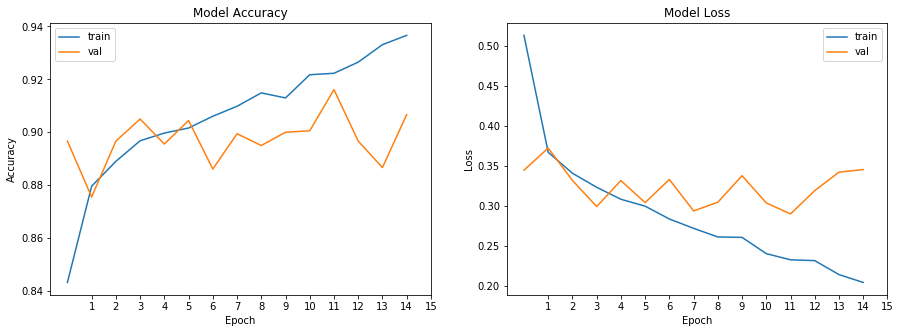

In [10]:
def plot_history(history):
    """Utility function for plotting the model's accuracy and loss."""
    
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set_xticks(np.arange(1, len(history.history['acc'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_xticks(np.arange(1, len(history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_history(fit_history)

# Evaluate performance on test set

In [33]:
def get_metrics(X, y):
    """Returns F1 score, false and true positive rate and ROC area under curve."""
    y_pred = cnn_pad.predict(X)  # softmax probabilities (each prediction has two entries)
    y_prob = y_pred[:,1]         # probabilities of postitve class
    y = np.argmax(y, axis=1)     # remove one-hot encoding
    
    fpr, tpr, _ = roc_curve(y, y_prob)  
    auc = roc_auc_score(y, y_prob)
    f1 = f1_score(y, np.argmax(y_pred, axis=1), average='micro')
    
    return f1, fpr, tpr, auc

def plot_roc_curve(fpr, tpr, auc, dataset):
    """Given the false and true positive rate, as well as the area under curve,
    this function plots the ROC curve for a given dataset."""
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = {:.2}'.format(auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic on {} set'.format(dataset))
    plt.legend(loc="lower right")
    plt.show()

Evaluating test set...
loss: 0.238 - acc: 0.932 - f1 score: 0.932


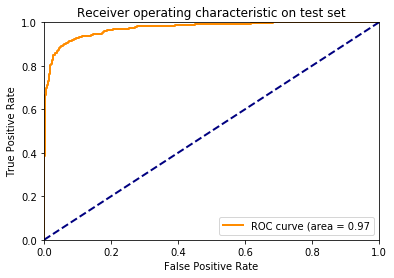

In [12]:
score_pad = cnn_pad.evaluate(X_test, y_test, verbose=0)
f1, fpr, tpr, auc = get_metrics(X_test, y_test)

print("Evaluating test set...")
print("loss: {:.3} - acc: {:.3} - f1 score: {:.3}".format(score_pad[0], score_pad[1], f1))
plot_roc_curve(fpr, tpr, auc, 'test')

# Evaluate Baseline

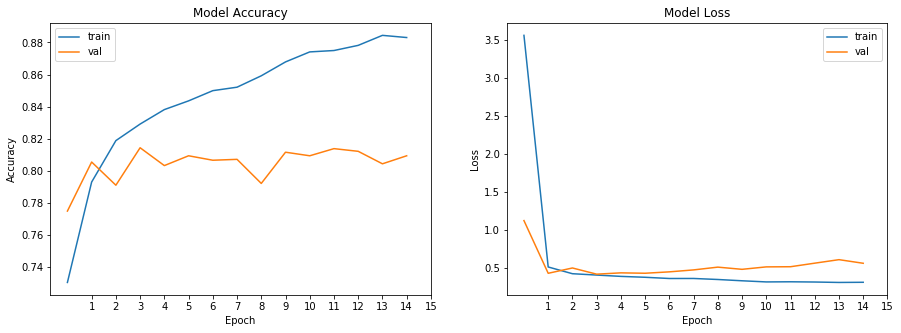

loss: 0.336 - acc: 0.881


In [37]:
plot_history(mlp_history)

test = baseline.evaluate(X_test, y_test, verbose=0)
print("loss: {:.3} - acc: {:.3}".format(test[0], test[1]))